In [19]:
# Cell 1: Imports and Setup (unchanged)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomApply, ColorJitter, RandomRotation
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import seaborn as sns
import random

print("✅ All libraries imported successfully!")

# Configuration
IMG_SIZE = 128  # Smaller images for less complexity
BATCH_SIZE = 8  # Reduce batch size due to limited data
LEARNING_RATE = 0.001
NUM_EPOCHS = 50  # Train longer with early stopping
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {DEVICE}")

✅ All libraries imported successfully!
🔧 Using device: cpu


In [21]:
# Cell 2: Enhanced Point Cloud to Multi-View Image
def load_point_cloud(file_path):
    """Load point cloud from various formats"""
    try:
        suffix = file_path.suffix.lower()
        if suffix == '.txt' or suffix == '.xyz':
            data = np.loadtxt(file_path)
        elif suffix == '.pts':
            with open(file_path, 'r') as f:
                lines = [line.strip().split() for line in f if line.strip()]
            data = []
            for parts in lines:
                if len(parts) >= 3:
                    try:
                        x, y, z = float(parts[0]), float(parts[1]), float(parts[2])
                        data.append([x, y, z])
                    except:
                        continue
            data = np.array(data)
        else:
            return None
        if len(data) == 0 or data.shape[1] < 3:
            return None
        return data[:, :3]
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def normalize_points(points):
    """Normalize point cloud to unit cube"""
    centroid = np.mean(points, axis=0)
    points = points - centroid
    m = np.max(np.sqrt(np.sum(points**2, axis=1)))
    if m > 0:
        points = points / m
    return points

def project_to_image(points, view='xy', img_size=128):
    """Project point cloud to 2D image from different views"""
    if view == 'xy':
        x, y = points[:, 0], points[:, 1]
    elif view == 'xz':
        x, y = points[:, 0], points[:, 2]
    elif view == 'yz':
        x, y = points[:, 1], points[:, 2]
    else:
        x, y = points[:, 0], points[:, 1]

    # Normalize to [0, 1]
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    y = (y - y.min()) / (y.max() - y.min() + 1e-8)

    # Flip y-axis to match image coordinates
    y = 1 - y

    # Create image
    image = np.zeros((img_size, img_size), dtype=np.float32)
    x_idx = (x * (img_size - 1)).astype(int)
    y_idx = (y * (img_size - 1)).astype(int)

    valid = (x_idx >= 0) & (x_idx < img_size) & (y_idx >= 0) & (y_idx < img_size)
    x_idx, y_idx = x_idx[valid], y_idx[valid]

    # Use density + height for intensity
    z_vals = points[valid, 2]
    z_norm = (z_vals - z_vals.min()) / (z_vals.max() - z_vals.min() + 1e-8)
    intensity = 0.5 + 0.5 * z_norm  # Base intensity from height

    for i in range(len(x_idx)):
        image[y_idx[i], x_idx[i]] = max(image[y_idx[i], x_idx[i]], intensity[i])

    return (image * 255).astype(np.uint8)

def point_cloud_to_multiview_image(points, img_size=128):
    """Generate a 3-channel image: each channel = different view"""
    if points is None or len(points) < 10:
        img = Image.new('RGB', (img_size, img_size), (0, 0, 0))
        return img

    points = normalize_points(points)

    xy = project_to_image(points, 'xy', img_size)
    xz = project_to_image(points, 'xz', img_size)
    yz = project_to_image(points, 'yz', img_size)

    # Stack as RGB channels
    rgb_array = np.stack([xy, xz, yz], axis=-1)
    return Image.fromarray(rgb_array)

In [22]:
# Cell 3: Dataset with Augmentation
class TreePointCloudDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None, img_size=128, augment=False):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.img_size = img_size
        self.augment = augment

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        points = load_point_cloud(self.file_paths[idx])
        if self.augment and points is not None and len(points) > 0:
            # Small random rotation for augmentation
            angle = random.uniform(0, 2 * np.pi)
            cos, sin = np.cos(angle), np.sin(angle)
            points[:, 0], points[:, 1] = cos*points[:,0] - sin*points[:,1], sin*points[:,0] + cos*points[:,1]

        image = point_cloud_to_multiview_image(points, self.img_size)
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Transforms with augmentation
train_transforms = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    # Normalize per channel (we'll compute stats later)
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transforms = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [23]:
class SimpleTreeCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleTreeCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Recreate dataset
all_file_paths, all_labels = load_tree_data(data_path)
if len(all_file_paths) == 0:
    raise ValueError("No data found!")

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)
num_classes = len(label_encoder.classes_)

# Stratified split
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_file_paths, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# Datasets
train_dataset = TreePointCloudDataset(train_paths, train_labels, transform=train_transforms, augment=True, img_size=IMG_SIZE)
val_dataset = TreePointCloudDataset(val_paths, val_labels, transform=test_transforms, img_size=IMG_SIZE)
test_dataset = TreePointCloudDataset(test_paths, test_labels, transform=test_transforms, img_size=IMG_SIZE)

# Handle class imbalance
class_counts = np.bincount(train_labels)
weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = weights[train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

🔍 Scanning directory: ../test
📁 Processing species: Oak
   Found 4 files
📁 Processing species: Douglas Fir
   Found 36 files
📁 Processing species: Spruce
   Found 31 files
📁 Processing species: Pine
   Found 5 files
📁 Processing species: Ash
   Found 7 files
📁 Processing species: Red Oak
   Found 19 files
📁 Processing species: Beech
   Found 32 files
✅ Total files loaded: 134
🏷️  Species found: ['Ash', 'Beech', 'Douglas Fir', 'Oak', 'Pine', 'Red Oak', 'Spruce']


In [28]:
# Cell: Training with early stopping
def train_model(model, train_loader, val_loader, epochs=50, patience=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

    best_acc = 0.0
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Train
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Val
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, preds = outputs.max(1)
                total += targets.size(0)
                correct += preds.eq(targets).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")

        scheduler.step(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_tree_model.pth")
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("🛑 Early stopping triggered.")
            break

    model.load_state_dict(torch.load("best_tree_model.pth"))
    return model, best_acc, train_losses, val_losses, train_accs, val_accs

In [29]:
# Train
model = SimpleTreeCNN(num_classes).to(DEVICE)
trained_model, best_val_acc, train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, NUM_EPOCHS
)

# Evaluate
def evaluate_model(model, test_loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, batch_preds = outputs.max(1)
            preds.extend(batch_preds.cpu().numpy())
            targets.extend(labels.numpy())
    return np.array(preds), np.array(targets)

y_pred, y_true = evaluate_model(trained_model, test_loader)
test_acc = accuracy_score(y_true, y_pred) * 100

print(f"\n🎯 Final Results:")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

Epoch  1 | Train Loss: 1.9751 | Acc: 18.82% | Val Loss: 1.9213 | Acc: 4.55%
Epoch  2 | Train Loss: 1.9109 | Acc: 25.88% | Val Loss: 1.8438 | Acc: 31.82%
Epoch  3 | Train Loss: 1.8203 | Acc: 25.88% | Val Loss: 1.7875 | Acc: 36.36%
Epoch  4 | Train Loss: 1.8096 | Acc: 27.06% | Val Loss: 1.7310 | Acc: 40.91%
Epoch  5 | Train Loss: 1.7240 | Acc: 29.41% | Val Loss: 1.5053 | Acc: 36.36%
Epoch  6 | Train Loss: 1.5072 | Acc: 40.00% | Val Loss: 1.4136 | Acc: 40.91%
Epoch  7 | Train Loss: 1.5358 | Acc: 30.59% | Val Loss: 1.3203 | Acc: 59.09%
Epoch  8 | Train Loss: 1.6176 | Acc: 30.59% | Val Loss: 1.3520 | Acc: 50.00%
Epoch  9 | Train Loss: 1.5803 | Acc: 29.41% | Val Loss: 1.3097 | Acc: 45.45%
Epoch 10 | Train Loss: 1.5344 | Acc: 37.65% | Val Loss: 1.3361 | Acc: 59.09%
Epoch 11 | Train Loss: 1.3770 | Acc: 43.53% | Val Loss: 1.2746 | Acc: 54.55%
Epoch 12 | Train Loss: 1.3711 | Acc: 45.88% | Val Loss: 1.1896 | Acc: 59.09%
Epoch 13 | Train Loss: 1.3955 | Acc: 45.88% | Val Loss: 1.3081 | Acc: 50.00%


Test Accuracy: 66.67%


<Figure size 1200x500 with 0 Axes>

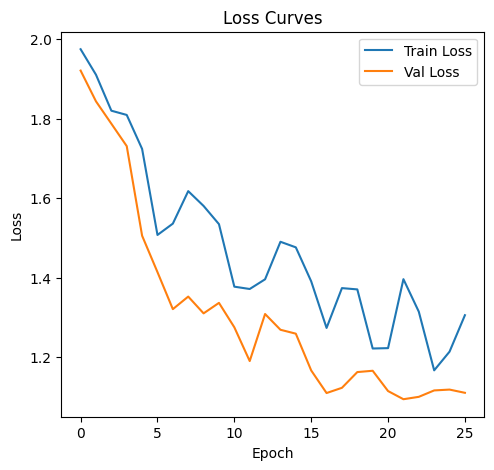

In [30]:
#priting the accuracy  final 
print(f"Test Accuracy: {test_acc:.2f}%")

plt.figure(figsize=(12, 5))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()